#Proyek Pertama - Part 2 : Analisis Sentimen Komentar Penilaian Barang Flash Sale Shopee


*   Nama: Michelle Angelina
*   Email: zmichelleangelina@gmail.com
*   ID Dicoding: mchelle_angelina

## Preparation

#### Import Library

In [5]:
## Library Imports
import requests
import pandas as pd
import re
import os
import time
import string
import nltk
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, InputLayer, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec
import numpy as np

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Cleansing Data and Labeling

In [6]:
df = pd.read_csv("flash_sale_reviews.csv")
df = df.dropna(subset=["username", "comment", "rating"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11224 entries, 0 to 14097
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  11224 non-null  object
 1   rating    11224 non-null  int64 
 2   comment   11224 non-null  object
 3   time      11224 non-null  object
 4   product   11224 non-null  object
dtypes: int64(1), object(4)
memory usage: 526.1+ KB
None


In [7]:
## Hapus Simbol dan Normalisasi teks menjadi huruf kecil
stopword_factory = StopWordRemoverFactory()
stop_words = set(stopword_factory.get_stop_words())
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s😊😢😂😍😭😘😎🤔👍👎😀😆🙂😔😑🙄😐😁❤️💔]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

df['cleaned_comment'] = df['comment'].apply(clean_text)

In [8]:
def label_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment"] = df["rating"].apply(label_sentiment)

## Skema 1: Ekstraksi Fitur TF-IDF with LSTM Model Training | 80/20 Dataset Split

#### 80/20  Split Dataset

In [9]:
X = df["cleaned_comment"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {len(X_train)}")
print(f"Testing data: {len(X_test)}")

Training data: 8979
Testing data: 2245


#### Ekstraksi Fitur dengan TF-IDF

In [10]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Fitur training: {X_train_tfidf.shape}")
print(f"Fitur testing: {X_test_tfidf.shape}")

Fitur training: (8979, 5000)
Fitur testing: (2245, 5000)


In [11]:
df.to_csv("flash_sale_reviews_preprocessed_tfidf.csv", index=False)
print("Data disimpan di flash_sale_reviews_preprocessed_tfidf.csv.")

Data disimpan di flash_sale_reviews_preprocessed_tfidf.csv.


#### LSTM Model

In [12]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Tokenization dan padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Membuat model LSTM
model_1 = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 kelas: positive, neutral, negative
])

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_1 = model_1.fit(
    X_train_pad, y_train_encoded,
    validation_data=(X_test_pad, y_test_encoded),
    epochs=12,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 158s 930ms/step - accuracy: 0.8546 - loss: 0.5210 - val_accuracy: 0.9033 - val_loss: 0.3027
Epoch 2/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 128s 910ms/step - accuracy: 0.9222 - loss: 0.2512 - val_accuracy: 0.9114 - val_loss: 0.2702
Epoch 3/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 127s 900ms/step - accuracy: 0.9359 - loss: 0.1968 - val_accuracy: 0.9091 - val_loss: 0.2822
Epoch 4/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 143s 910ms/step - accuracy: 0.9459 - loss: 0.1571 - val_accuracy: 0.9091 - val_loss: 0.3018
Epoch 5/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 143s 918ms/step - accuracy: 0.9481 - loss: 0.1441 - val_accuracy: 0.9016 - val_loss: 0.3201


In [13]:
loss, accuracy = model_1.evaluate(X_test_pad, y_test_encoded, verbose=1)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9129 - loss: 0.2600
Testing Accuracy: 91.14%


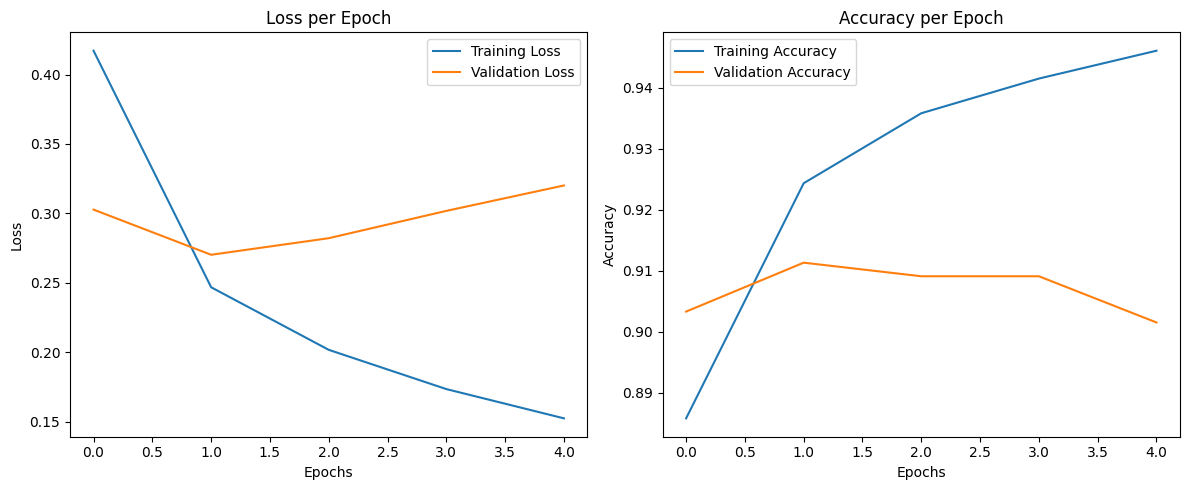

In [14]:
# Plot loss dan accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Skema 2: Ekstraksi Fitur Word2Vec with LSTM Model Training | 85/15 Dataset Split

#### 85/15 Split Dataset

In [15]:
X = df["cleaned_comment"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"Training data: {len(X_train)}")
print(f"Testing data: {len(X_test)}")

Training data: 9540
Testing data: 1684


#### Ekstraksi Fitur dengan Word2Vec

In [16]:
tokenized_sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2)

def transform_to_w2v(data, w2v_model):
    return np.array([
        np.mean([w2v_model.wv[word] for word in sentence.split() if word in w2v_model.wv] or [np.zeros(100)], axis=0)
        for sentence in data
    ])

X_train_w2v = transform_to_w2v(X_train, w2v_model)
X_test_w2v = transform_to_w2v(X_test, w2v_model)

In [17]:
df.to_csv("flash_sale_reviews_preprocessed_w2v.csv", index=False)
print("Data disimpan di flash_sale_reviews_preprocessed_w2v.csv.")

Data disimpan di flash_sale_reviews_preprocessed_w2v.csv.


#### LSTM Model

In [18]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_w2v = X_train_w2v.reshape(X_train_w2v.shape[0], X_train_w2v.shape[1], 1)
X_test_w2v = X_test_w2v.reshape(X_test_w2v.shape[0], X_test_w2v.shape[1], 1)

model_2 = Sequential([
    InputLayer(input_shape=(100, 1)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_2 = model_2.fit(
    X_train_w2v, y_train_encoded,
    validation_data=(X_test_w2v, y_test_encoded),
    epochs=12,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


150/150 ━━━━━━━━━━━━━━━━━━━━ 113s 699ms/step - accuracy: 0.8756 - loss: 0.5519 - val_accuracy: 0.8741 - val_loss: 0.3994
Epoch 2/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 697ms/step - accuracy: 0.8873 - loss: 0.3880 - val_accuracy: 0.8741 - val_loss: 0.4056
Epoch 3/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 694ms/step - accuracy: 0.8896 - loss: 0.3739 - val_accuracy: 0.8824 - val_loss: 0.3955
Epoch 4/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 105s 698ms/step - accuracy: 0.8919 - loss: 0.3621 - val_accuracy: 0.8806 - val_loss: 0.3857
Epoch 5/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 104s 695ms/step - accuracy: 0.8969 - loss: 0.3521 - val_accuracy: 0.8735 - val_loss: 0.3931
Epoch 6/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 696ms/step - accuracy: 0.8878 - loss: 0.3711 - val_accuracy: 0.8824 - val_loss: 0.3892
Epoch 7/12
150/150 ━━━━━━━━━━━━━━━━━━━━ 144s 710ms/step - accuracy: 0.8899 - loss: 0.3673 - val_accuracy: 0.8812 - val_loss: 0.3946


In [19]:
loss, accuracy = model_2.evaluate(X_test_w2v, y_test_encoded, verbose=1)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.8776 - loss: 0.4001
Testing Accuracy: 88.06%


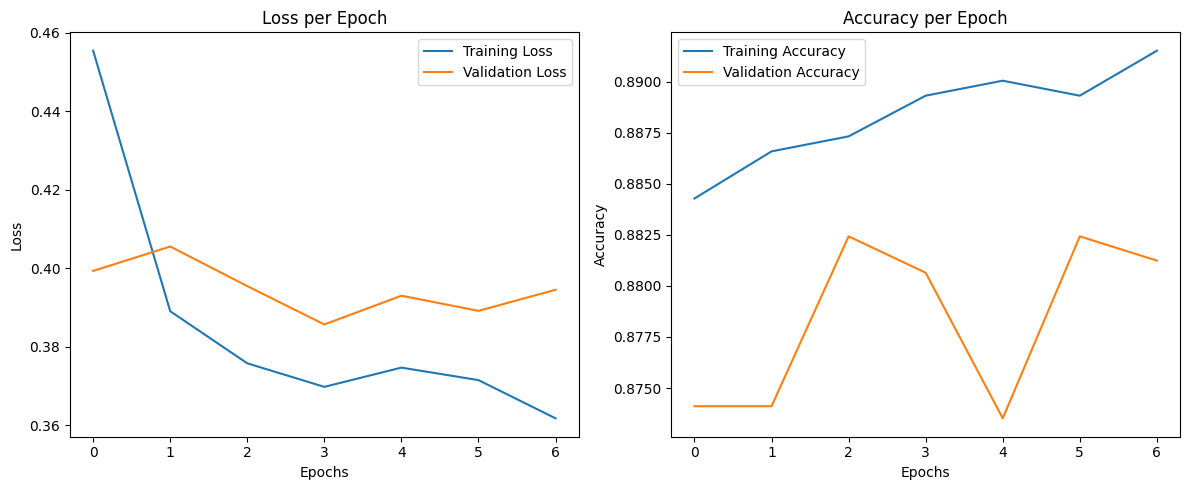

In [20]:
# Plot loss dan accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Skema 3: Ekstraksi Fitur Count Vectorizer with CNN Model Training | 80/20 Dataset Split

#### 80/20 Split Dataset

In [21]:
X = df["cleaned_comment"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data: {len(X_train)}")
print(f"Testing data: {len(X_test)}")

Training data: 8979
Testing data: 2245


#### Ekstraksi Fitur dengan Count Vectorizer

In [22]:
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_cv = count_vectorizer.fit_transform(X_train).toarray()
X_test_cv = count_vectorizer.transform(X_test).toarray()

In [23]:
df.to_csv("flash_sale_reviews_preprocessed_cv.csv", index=False)
print("Data disimpan di flash_sale_reviews_preprocessed_cv.csv.")

Data disimpan di flash_sale_reviews_preprocessed_cv.csv.


#### CNN Model

In [25]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_cv = X_train_cv.reshape(X_train_cv.shape[0], X_train_cv.shape[1], 1)
X_test_cv = X_test_cv.reshape(X_test_cv.shape[0], X_test_cv.shape[1], 1)

model = Sequential([
    InputLayer(input_shape=(X_train_cv.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_cv, y_train_encoded,
    validation_data=(X_test_cv, y_test_encoded),
    epochs=12,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.8727 - loss: 0.4136 - val_accuracy: 0.9069 - val_loss: 0.3076
Epoch 2/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.9256 - loss: 0.2241 - val_accuracy: 0.9091 - val_loss: 0.2865
Epoch 3/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9327 - loss: 0.1868 - val_accuracy: 0.9109 - val_loss: 0.3013
Epoch 4/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9473 - loss: 0.1571 - val_accuracy: 0.9020 - val_loss: 0.3293
Epoch 5/12
141/141 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9578 - loss: 0.1237 - val_accuracy: 0.8967 - val_loss: 0.3674


In [26]:
loss, accuracy = model.evaluate(X_test_cv, y_test_encoded, verbose=1)
print(f"Testing Accuracy: {accuracy * 100:.2f}%")

71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.9095 - loss: 0.2778
Testing Accuracy: 90.91%


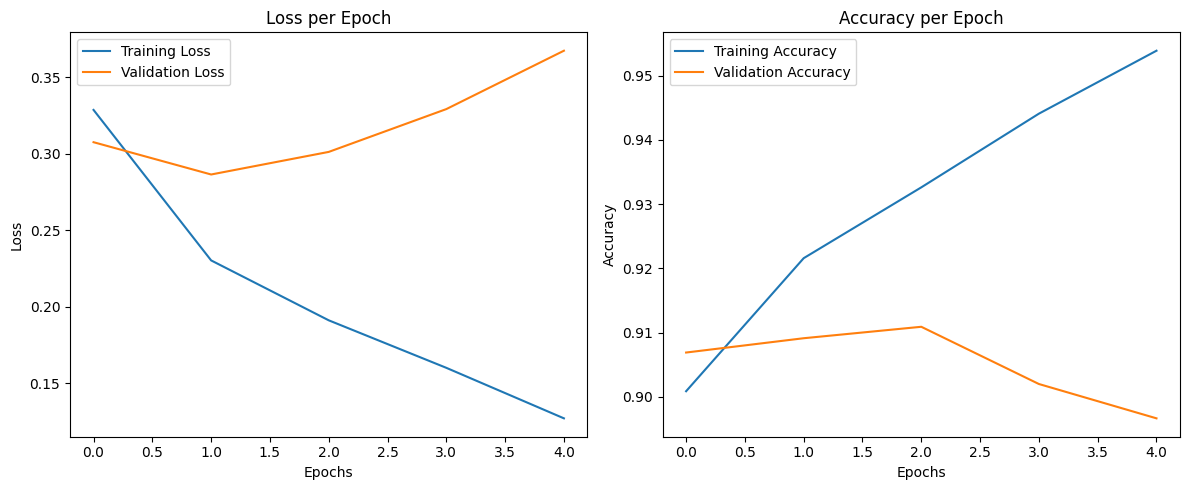

In [27]:
# Plot loss dan accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model Inference

#### Menggunakan Skema 3 (Count Vectorizer Feature Extraction with CNN Model Training) dengan Hasil Training dan Testing Tertinggi

In [34]:
def predict_sentiment(text, model_1, tokenizer, max_length, label_encoder):
    # Tokenize the input text
    sequence = tokenizer.texts_to_sequences([text])

    # Pad the sequence to match the length of the training data
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    # Reshape the padded sequence to match the model's input shape
    padded_sequence = padded_sequence.reshape((padded_sequence.shape[0], max_length, 1))

    # Predict the sentiment
    prediction = model_1.predict(padded_sequence)

    # Decode the prediction into the sentiment label
    sentiment = label_encoder.inverse_transform([np.argmax(prediction)])

    return sentiment[0]

# Contoh penggunaan
sample_text = "jelek banget ini, gak mau beli lagi di sini"

# Pastikan max_length sama dengan panjang input model
max_length = X_train_cv.shape[1]

# Prediksi sentimen
predicted_sentiment = predict_sentiment(sample_text, model_1, tokenizer, max_length, label_encoder)

# Print hasil prediksi
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Sentiment: negative


In [37]:
sample_text = "Produk ini bagus banget aku suka, bakal beli lagi di sini"
predicted_sentiment = predict_sentiment(sample_text, model, tokenizer, max_length, label_encoder)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Sentiment: positive


In [38]:
sample_text = "tidak terlalu sepadan dengan harga, so so"
predicted_sentiment = predict_sentiment(sample_text, model, tokenizer, max_length, label_encoder)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Sentiment: neutral
